<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

## Introduction


This Jupyter notebook includes examples on:
- Access GFSC products through the HDA API
- Read and visualize GFSC products
- Manipulate the QCFLAGS layer to filter data according to sensor type
- Manipulate the AT layer to filter data according to data age

## CLMS HRSI GFSC Product


The daily cumulative Gap-filled Fractional Snow Cover (GFSC) product is generated in near real-time (NRT) for the entire EEA38+UK domain.  It is based on SAR data from the Sentinel-1 (S1) constellation and  
optical data from the Sentinel-2 (S2) constellation. This product merges the latest observations to provide a spatially complete overview of snow conditions.

The GFSC product offers the extent of snow cover per pixel as a percentage (0% – 100%) with a spatial resolution of 60m x 60m. It utilizes Fractional Snow Cover (FSC), Wet/Dry Snow (WDS), and SAR Wet Snow  
(SWS) products as inputs to create a comprehensive composite of snow conditions, reducing observational gaps caused by clouds and limited sensor coverage on a daily basis. The product applies the on-ground  
FSC and SWS data and presents the combined information as FSC.

For more information about the GFSC product, please refer to the <a href="https://land.copernicus.eu/user-corner/technical-library/hrsi-snow-pum">Product User Manual (PUM).</a>

## Environment Setup
Before we begin, we need to prepare our environment by installing and importing the necessary R packages.

### Install the WEkEO HDA Client

The WEkEO HDA client is a R package.

To install the WEkEO HDA client using the package management system, run the following command on Unix/Linux:

In [ ]:
install.packages('hdar')

### Load Required Libraries

Please verify that the following requirements are installed before proceeding to the next step:
   - `xmltodict`

In [40]:
library(lubridate)
library(terra)
library(xml2)

library(ggplot2)
library(gridExtra)
library(scales)

library(magrittr)


Attaching package: ‘magrittr’


The following objects are masked from ‘package:terra’:

    extract, inset




### Load WEkEO HDA client

## HDA Client Setup

### WEkEO Account Registration

If you don't have a WEkEO account, please self-register at the <a href='https://my.wekeo.eu/web/guest/user-registration' target='_blank'>WEkEO registration page</a>.

### API Authentication

To interact with WEkEO's Harmonised Data Access API, ensure the file `$HOME/.hdarc` exists with the URL to the API endpoint, and your username and password.  
For example, to check if the `.hdarc` file exists in the $HOME directory, open a terminal and run the following command:

In [24]:
ls $HOME/.hdarc

ERROR: Error in ls$HOME: object of type 'closure' is not subsettable


Then, copy the code below into the file `$HOME/.hdarc` (in your Unix/Linux environment) and replace the placeholders with your WEkEO account credentials:

```yaml
user_name: #############
password: #############

The hda client provides a fully compliant R client that can be used to search and download products using the Harmonized Data Access WEkEO API.
HDA is RESTful interface allowing users to search and download WEkEO datasets.
Documentation about its usage can be found at the <a href='https://www.wekeo.eu/' target='_blank'>WEkEO website</a>.

In [3]:
library(hdar)

hda_client <- hdar::Client$new()

<hr>

## Process data with HDA Client

### Search products

To search datasets, you need to construct a JSON query. You can create this query JSON manually or copy it from a manual search in the WEkEO Data Explorer.
<div>
<figure><img src='../../media/snow_and_ice/apicall.png' height='400px' />
    <figcaption><i>S2 Tile T32VMN</i></figcaption>
</figure>
</div>

In [4]:
query <- list(
  dataset_id = "EO:CRYO:DAT:HRSI:GFSC",
  bbox = c(
    4.0488399662761605,
    60.64709920038568,
    9.213189474039462,
    61.81526952644772
  ),
  observed_start = "2022-03-13T00:00:00.000Z",
  observed_end = "2022-03-13T00:00:00.000Z",
  cloudCover = "30"
)

For our working example, we will create a query that specifies a single day and tile. In this case, we will use tile T32TVM in the Scandinavian mountains on March 13, 2022:

<figure><img src='../../media/snow_and_ice/T32VMN.png' width='400px' />
    <figcaption><i>S2 Tile T32VMN</i></figcaption>
</figure>

In [5]:
# query by tile and date
tile <- "T32VMN"
day <- "13.03.2022"

query <- list(
  dataset_id = "EO:CRYO:DAT:HRSI:GFSC",
  observed_start = format(dmy(day), "%Y-%m-%dT00:00:00.000Z"),
  observed_end = format(dmy(day), "%Y-%m-%dT00:00:00.000Z"),
  productIdentifier = tile
)

Use the HDA Client and the query to search the database, configuring a shorter timeout to handle potential connection or account issues:

In [ ]:
prod_dir <- normalizePath("../../data/processing/snow-and-ice/products")
download_dir <- normalizePath("../../data/download/snow-and-ice/products")

hda_success <- FALSE
tryCatch({
  matches <- hda_client$search(query)
  hda_success <- TRUE
}, error = function(e) {
  hda_success <- FALSE
  print(e)
})

If a problem occurs, such as the user not being registered, create an object to handle any previously downloaded products:

In [7]:
if (!hda_success) {
  matches <- list()
  for (product in list.files(prod_dir)) {
    try({
      # test if folder name fits the product filename format
      day <- as.Date(substr(strsplit(product, '_')[[1]][2], 1, 8), "%Y%m%d")
      curation_time <- as.POSIXct(as.numeric(strsplit(product, '_')[[1]][6]), origin="1970-01-01", tz="UTC")
      match <- list(results = list(list(productInfo = list(product = product))))
      matches <- append(matches, list(match))
    }, silent = TRUE)
    if (inherits(last.warning, "try-error")) {
      cat("A folder/file in products folder is not a valid product. Skipped.\n")
      last.warning <- NULL
    }
  }
  cat(length(matches), "products found in products folder.\n")
} else {
  cat("HDA Client response successful. HDA Client will be used.\n")
}

HDA Client response successful. HDA Client will be used.


Parse the response from the HDA client and create a list of dictionaries with additional metadata to manage the data more efficiently.  
The list structure is as follows:

In [ ]:
[
    {
        'title': str, 
        'tile': str, 
        'day': datetime.datetime, 
        'curation_time': datetime.datetime, 
        'dir': str
    },
    {
        'title': str, 
        'tile': str, 
        'day': datetime.datetime, 
        'curation_time': datetime.datetime, 
        'dir': str
    }
];

# only for descriptive usage. this cell does not do anything.

In [ ]:
cat(length(matches$results), "products found\n")

# reparse response for a custom list
products <- list()
for (match in matches$results) {        
  product <- match$id
  tile <- strsplit(product, '_')[[1]][4]
  day <- as.Date(substr(strsplit(product, '_')[[1]][2], 1, 8), "%Y%m%d")
  curation_time <- as.POSIXct(as.numeric(strsplit(product, '_')[[1]][6]), origin = "1970-01-01", tz = "UTC")
  products <- append(products, list(list(
    title = product,
    tile = tile,
    day = day,
    curation_time = curation_time,
    dir = file.path(prod_dir, paste0(product))
  )))
}

# summarize products 
cat("Day\t\tTile\tCuration time\n")
for (product in products) {
  cat(
    paste(
      format(product$day, "%Y-%m-%d"), product$tile, format(product$curation_time, "%Y-%m-%d %H:%M:%S"),
      sep = "\t"
    ), "\n"
  )
}

if (length(products) == 0) {
  cat("No products are available on the disk. Rest of the notebook will not work.\n")
}

### Download Data

Download the products to temporary folders and then move them to the "products directory" defined at the beginning.
<li>Products are downloaded as zip files but without file extensions. Extract the files before moving them to the products directory.</li>
<li>If the products have already been downloaded (i.e., the folder exists), skip the download.</li>

In [ ]:
dir.create(prod_dir, showWarnings = FALSE, recursive = TRUE)
dir.create(download_dir, showWarnings = FALSE, recursive = TRUE)

for (product in products) {
  if (!(product$title %in% list.files(prod_dir))) {
    
    # find the products in the HDA client response and call download method
    matches$download(download_dir)
    
    # unzip
    zip_file <- file.path(download_dir, paste0(product$title, '.zip'))
    unzip(zip_file, exdir = prod_dir)
    
    cat(product$title, "was downloaded to", prod_dir, "\n")
  } else {
    cat(product$title, "is already in product directory\n")
  }
  # add directory information to be used later
  product$dir <- file.path(prod_dir, product$title)
}

### Read and Visualize Products

Create functions to read product rasters and metadata, and store them compactly in dictionaries.  
The main function will take the directory and title of the product as arguments and return a single dictionary containing all the data.

In [236]:
# Define the function to read TIFF images
read_tif <- function(file_tif) {
  ds <- rast(file_tif)
  # Projection
  proj <- crs(ds, proj = TRUE)
  # Colormap
  cmp <- NULL
  color_table <- coltab(ds)

  if (!is.null(color_table) && !is.null(color_table[[1]])) {
    cmp <- apply(color_table[[1]], 1, function(color) {
      rgb(color["red"] / 255, color["green"] / 255, color["blue"] / 255)
    })
  }
  list(data = ds, proj = proj, cmp = cmp)
}

# Define the function to read all rasters and XML metadata
read_product_files <- function(directory, title) {

  gf_result <- read_tif(file.path(directory, paste0(title, "_GF.tif")))
  proj_gf <- gf_result$proj
  cmp_gf <- gf_result$cmp
  gf <- gf_result$data

  qc_result <- read_tif(file.path(directory, paste0(title, "_QC.tif")))
  cmp_qc <- qc_result$cmp
  qc <- qc_result$data

  qcflags <- read_tif(file.path(directory, paste0(title, "_QCFLAGS.tif")))$data
  at <- read_tif(file.path(directory, paste0(title, "_AT.tif")))$data

  # read xml metadata
  meta <- as_list(read_xml(file.path(directory, paste0(title, "_MTD.xml"))))

  list(gf = gf, cmp_gf = cmp_gf, qc = qc, cmp_qc = cmp_qc, qcflags = qcflags, at = at, meta = meta, proj_gf = proj_gf)
}

# Define the function to organize data into a single list
read_product_data <- function(directory, title) {
  product_files <- read_product_files(directory, title)

  # make a list for convenient reading
  productData <- list(
    GF = product_files$gf,
    GF_cmp = product_files$cmp_gf,
    QC = product_files$qc,
    QC_cmp = product_files$cmp_qc,
    QCFLAGS = product_files$qcflags,
    AT = product_files$at,
    meta = product_files$meta,
    proj = product_files$proj_gf
  )

  return(productData)
}


First, we will read the data and metadata of the first product in the list using the functions and directories defined previously:

In [237]:
product <- products[[1]]
productData <- read_product_data(product$dir, product$title)

The color table in the product includes a "No data" label (255) set as transparent. Since the notebook background is white, "No data" pixels will be displayed as white, making them indistinguishable from snow pixels. Therefore, we should use a different color for "No data" pixels:

In [239]:
productData$GF_cmp[[length(productData$GF_cmp)]] <- rgb(255/255, 192/255, 203/255)

The default figure size of "matplotlib" is too small for the screen, so we need to modify it to enhance visibility.

In [240]:
options(repr.plot.width = 14, repr.plot.height = 12)

Next, we will draw the GF layer using matplotlib:

In [ ]:
gf_data <- as.data.frame(productData$GF, xy = TRUE)
colnames(gf_data) <- c('x', 'y', 'value')

# Plot the GF data
ggplot(gf_data, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) + 
  # scale_fill_gradientn(colours = custom_palette(256), limits = c(0, 255)) +
  scale_fill_gradientn(colors = productData$GF_cmp, limits = c(0, 255)) + 
  coord_fixed() +
  theme_void() +
  theme(
    legend.position = "right",
    legend.direction = "vertical",
    legend.justification = "center",
    legend.key.height = unit(4, "cm"),
    legend.box.margin = unit(c(0, 2, 2, 2), "cm"),
    legend.text = element_text(size = 21),
    legend.title = element_blank()
  ) +
  labs(fill = "Value")

This layer shows gap-filled FSC data, which includes data from up to 7 days before. The XML metadata in the product contains information from all the input products, allowing us to list the input products, their sensing times, and calculate the age of the data relative to the GFSC product.

In [ ]:
cat("TYPE\tSENSING TIME\t\tAGE\n")

metadata <- productData$meta[["MD_Metadata"]][["series"]][["DS_OtherAggregate"]]

for (input_meta in metadata) {
  input_title <- input_meta$MD_Metadata$fileIdentifier$CharacterString[[1]]
  if (is.null(input_title)) {
    next()
  }

  input_type <- strsplit(input_title, "_")[[1]][[1]]

  identification_info <- input_meta$MD_Metadata$identificationInfo
  extent <- identification_info$MD_DataIdentification[["extent"]][["EX_Extent"]]
  temporal_element <- extent[["temporalElement"]][["EX_TemporalExtent"]]
  time_period <- temporal_element[["extent"]][["TimePeriod"]]
  begin_position <- time_period[["beginPosition"]]

  input_start_date <- ymd_hms(begin_position)
  input_age <- difftime(product$day + days(1), input_start_date, units = "secs")

  input_age_period <- seconds_to_period(input_age)
  formatted_age <- sprintf(
    "%d days, %d:%02d:%02.0f",
    as.integer(input_age_period@day),
    as.integer(input_age_period@hour),
    minute(input_age_period),
    second(input_age_period)
  )

  formatted_start_date <- format(input_start_date, "%Y-%m-%d %H:%M:%S")

  cat(input_type, formatted_start_date, formatted_age, "\n", sep = "\t")
}


Although the XML metadata provides temporal information as a list, the AT layer contains temporal information for each pixel. The sensing time of each pixel is encoded as "Unix time" (seconds since January 1, 1970) in the AT layer. We can create a raster of "age" to show the age of the data in days (decimal) from the end of the product day (e.g., the age for a sensing at noon on the same day will be 12 hours).

In [74]:
product_midnight_timestamp <- as.numeric(as.POSIXct(product$day) + days(1))
productData$age <- (product_midnight_timestamp - productData$AT) / (60 * 60 * 24)

When "No data" is present, the AT layer has a value of "0". To handle this, we can use "NaN" in the new age raster instead.

In [75]:
productData$age[productData$AT == 0] <- NA

Finally, we will draw the new "age" raster using matplotlib:

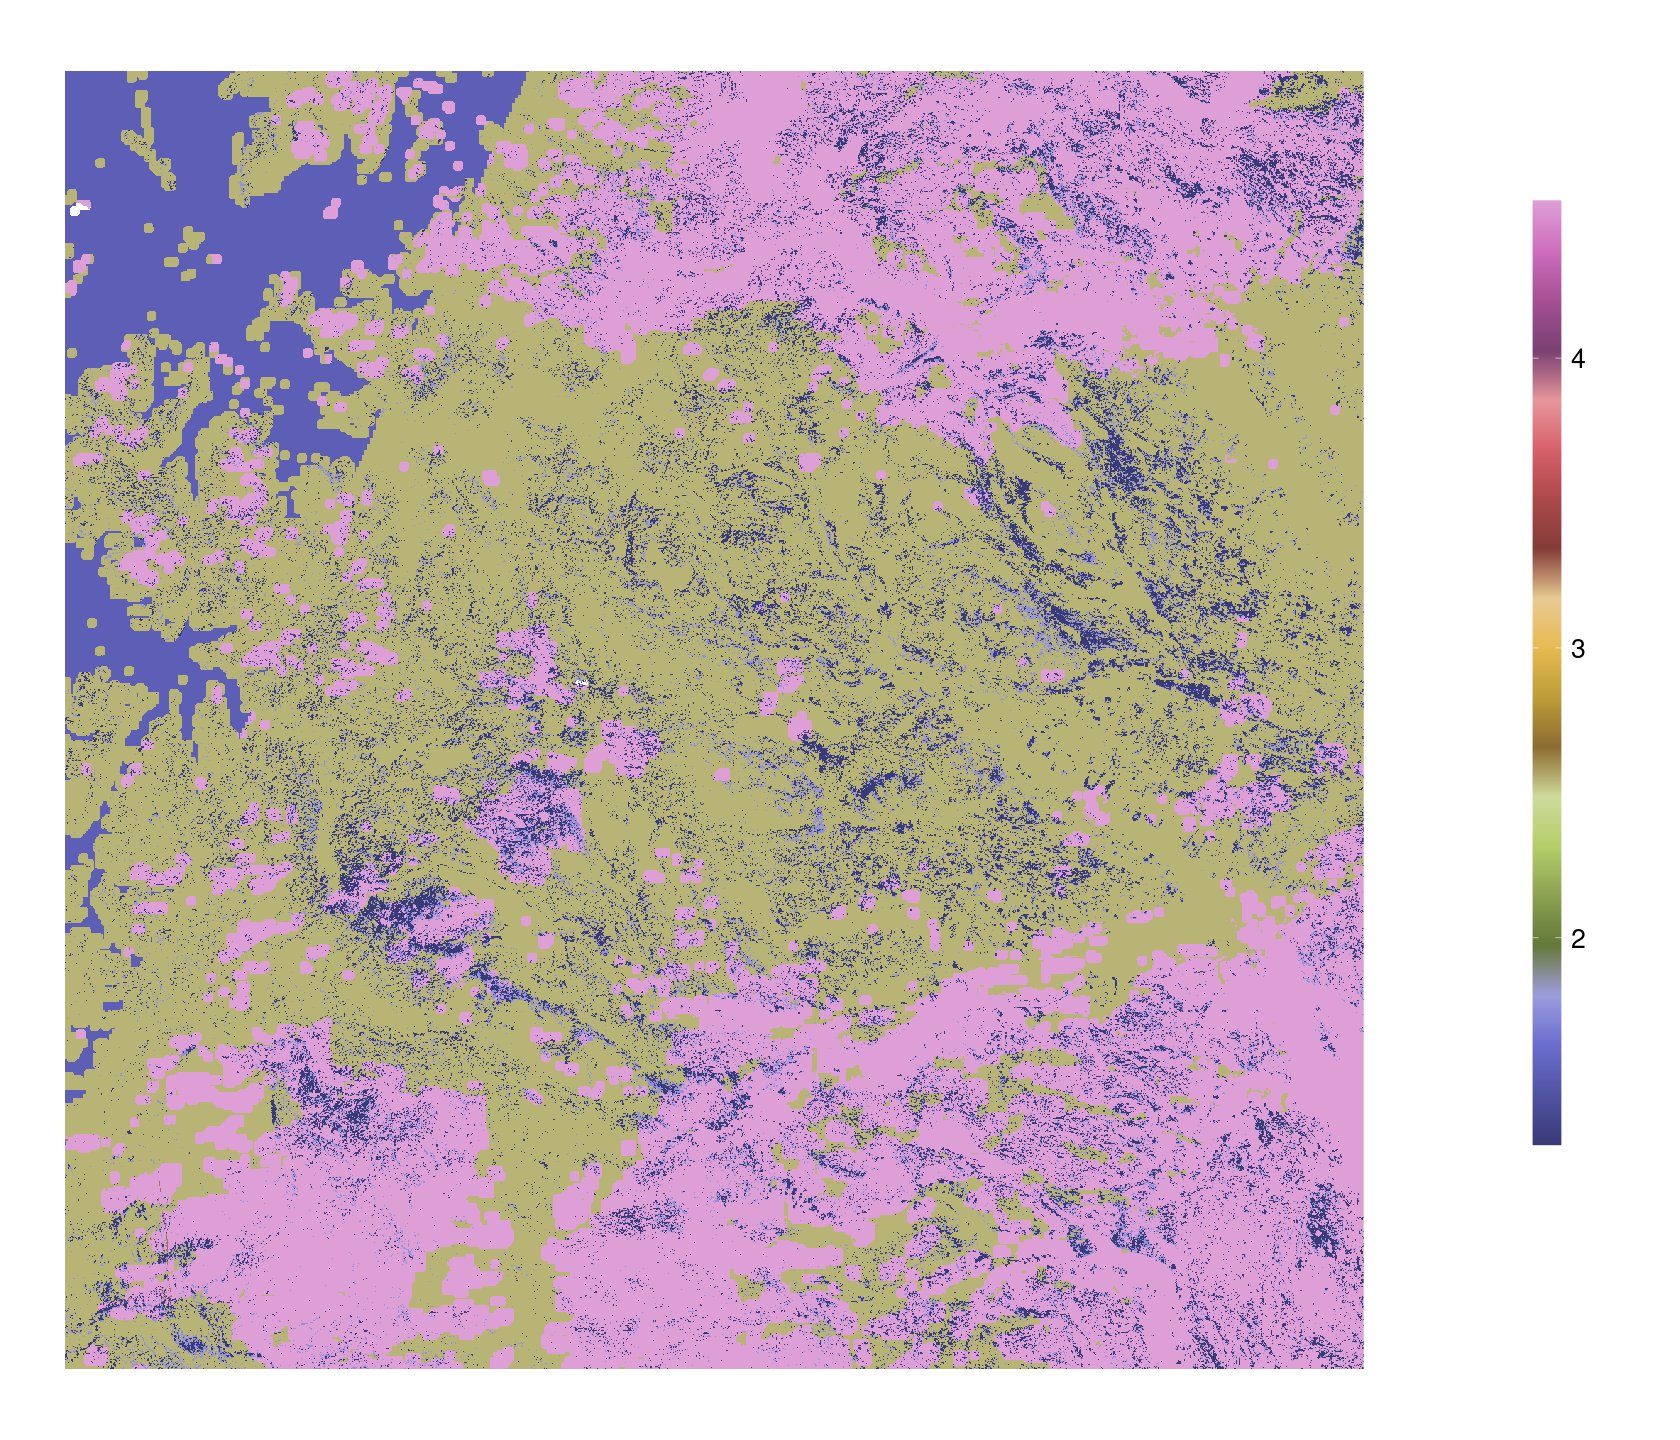

In [96]:
options(repr.plot.width = 14, repr.plot.height = 12)

tab20b_colors <- c(
  "#393b79", "#5254a3", "#6b6ecf", "#9c9ede",
  "#637939", "#8ca252", "#b5cf6b", "#cedb9c",
  "#8c6d31", "#bd9e39", "#e7ba52", "#e7cb94",
  "#843c39", "#ad494a", "#d6616b", "#e7969c",
  "#7b4173", "#a55194", "#ce6dbd", "#de9ed6"
)

age_data <- as.data.frame(productData$age, xy = TRUE)
colnames(age_data) <- c('x', 'y', 'value')

ggplot(age_data, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) + 
  scale_fill_gradientn(colours = tab20b_colors, values = rescale(1:20)) +
  coord_fixed() +
  theme_void() +
  theme(
    legend.position = "right",
    legend.direction = "vertical",
    legend.justification = "center",
    legend.key.height = unit(4, "cm"),
    legend.box.margin = unit(c(0, 2, 2, 2), "cm"),
    legend.text = element_text(size = 16),
    legend.title = element_blank()
  ) +
  labs(fill = "Age")

### Manipulating AT layer to filter out data according to age of the pixels

Using the age raster, we can filter out pixels that are "too old" for our analysis. We will create a new GF raster that includes only the pixels with an "age" of no more than 4 days (i.e., data that is at most 3 days old).
<table>
<tr>
<td>
Note: An "invalid value encountered" warning may appear due to np.nan values in the age raster, but these pixels will be excluded from the results and won't affect the outcome.
</td>
</tr>
</table>

In [ ]:
# Convert rasters to data frames for ggplot
gf_df <- as.data.frame(productData$GF, xy = TRUE) %>% setNames(c("x", "y", "value"))
age_df <- as.data.frame(productData$age, xy = TRUE) %>% setNames(c("x", "y", "value"))

gf_4days <- productData$GF
values(gf_4days)[values(productData$age) > 4] <- 255
gf_4days_df <- as.data.frame(gf_4days, xy = TRUE) %>% setNames(c("x", "y", "value"))

# Define custom color map and theme
color_map <- scale_fill_gradientn(
  colors = productData$GF_cmp,
  limits = c(0, 255)
)
theme <- theme_void() +
  theme(
    legend.position = "none",
    plot.title = element_text(hjust = 0.5),
    panel.border = element_rect(
      color = "black",
      fill = NA,
      size = 1
    )
  )


# Create plots
p1 <- ggplot(gf_df, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) +
  coord_fixed() +
  ggtitle("GF") +
  color_map +
  theme

p2 <- ggplot(age_df, aes(x = x, y = y, fill = value <= 4)) +
  geom_raster(interpolate = FALSE) +
  coord_fixed() +
  ggtitle("4 Days Mask") +
  scale_fill_manual(values = c("TRUE" = "green", "FALSE" = "purple")) +
  theme

p3 <- ggplot(gf_4days_df, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) +
  coord_fixed() +
  ggtitle("GF 4 Days") +
  color_map +
  theme

# Arrange the plots in a grid with spacing
options(repr.plot.width = 18, repr.plot.height = 6)
grid.arrange(p1, p2, p3, ncol = 3, padding = unit(1, "cm"))


### Manipulating QCFLAGS layer to filter out data according to sensor type of the pixels

The QCFLAGS layer is encoded bitwise, containing information for seven different cases in a combined format. Therefore, reading integer values directly from the raster will not be meaningful.

Next, we will draw the QCFLAGS raster using matplotlib:

In [ ]:
gf_data <- as.data.frame(productData$QCFLAGS, xy = TRUE)
colnames(gf_data) <- c("x", "y", "value")

# Set plot size
options(repr.plot.width = 12, repr.plot.height = 10)

# Plot the GF data
ggplot(gf_data, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) +
  scale_fill_gradient(low = "white", high = "black", na.value = "white") +
  coord_fixed() +
  ggtitle("QCFLAGS") +
  theme_void() +
  theme(
    plot.title = element_text(hjust = 0.5), panel.border = element_rect(
      color = "black",
      fill = NA,
      size = 1
    ),
    legend.position = "right",
    legend.direction = "vertical",
    legend.justification = "center",
    legend.key.height = unit(4, "cm"),
    legend.box.margin = unit(c(0, 2, 2, 2), "cm"),
    legend.text = element_text(size = 16),
    legend.title = element_blank()
  ) +
  labs(fill = "Value")


We need to read the raster bit by bit and interpret the information according to the guidelines in  <a href="https://land.copernicus.eu/user-corner/technical-library/hrsi-snow-pum">the product user manual:</a>

➔ bit 0: sun elevation angle too
low for an accurate
topographic correction (from
MAJA) (active=1) (only valid if
bit 6 is 0)

➔ bit 1: solar elevation angle
tangent to slope (from MAJA)
(active=1) (only valid if bit 6
is 0)

➔ bit 2: water (from EU-Hydro)
(active=1)

➔ bit 3: TCD too high for
accurate forest correction
(TCD>90%) (active=1) (only
valid if bit 6 is 0)

➔ bit 4: snow detected under
thin clouds (active=1) (only
valid if bit 6 is 0)

➔ bit 5: TCD not defined or not
available (active=1) (only
valid if bit 6 is 0)

➔ bit 6: sensor type of the
satellite data (optical=0,
radar=1)

Create a function that uses bit operations to read a single bit as a boolean raster.

In [168]:
getBit <- function(raster_data, bit) {
  data_matrix <- as.matrix(raster_data, wide = TRUE)

  mask <- bitwShiftR(data_matrix, bit) %>% bitwAnd(1)
  mask_matrix <- matrix(mask != 0, nrow = nrow(data_matrix), ncol = ncol(data_matrix))

  rast(mask_matrix, extent = ext(raster_data), crs = crs(raster_data))
}

Read all the bits and visualize them using matplotlib.

In [ ]:
# Function to create a plot for a specific bit
create_plot <- function(bit, data) {
  bit_data <- getBit(data, bit)
  bit_df <- as.data.frame(bit_data, xy = TRUE)
  colnames(bit_df) <- c("x", "y", "value")

  bit_df$numeric_value <- ifelse(bit_df$value == TRUE, 1, 0) %>% factor(levels = c(0, 1))

  ggplot(bit_df, aes(x = x, y = y, fill = numeric_value)) +
    geom_raster(interpolate = FALSE) +
    scale_fill_manual(values = c("0" = "white", "1" = "black")) +
    coord_fixed() + # Ensure aspect ratio is fixed
    theme_void() +
    theme(
      legend.position = "none",
      plot.title = element_text(hjust = 0.5),
      panel.border = element_rect(
        color = "black",
        fill = NA,
        size = 1
      ),
      plot.margin = unit(c(0, 0, 0, 0), "cm"),
    ) +
    ggtitle(paste("Bit", bit))
}

options(repr.plot.width = 12, repr.plot.height = 8)

# Create plots for bits 1 to 6
plots <- lapply(1:6, create_plot, data = productData$QCFLAGS)

# Arrange the plots in a grid
grid.arrange(
  grobs = plots, ncol = 3,
  padding = unit(1, "cm")
)


Another example of how to read the QCFLAGS raster can be found in "Webinar #2 (13 Oct. 2022): High Resolution Snow and Ice Monitoring" on the <a href="https://land.copernicus.eu/pan-european/biophysical-parameters/high-resolution-snow-and-ice-monitoring/user-section">CLMS HRSI User Section website.</a>

Now, we can use the same function to filter or utilize the GF layer based on different information from QCFLAGS. First, we can separate the GF raster by sensor type: if Bit 6 is 1, the pixel is from radar (S1); if Bit 6 is 0, the sensor is optical (S2). We can create rasters and replace the filtered values with the "no data" value (255):

In [158]:
gf_optical <- productData$GF
gf_optical[getBit(productData$QCFLAGS, 6)] <- 255

gf_radar <- productData$GF
gf_radar[!getBit(productData$QCFLAGS, 6)] <- 255

Visualize the separated rasters together using matplotlib.

In [ ]:
gf_optical_df <- as.data.frame(gf_optical, xy = TRUE) %>% setNames(c("x", "y", "value"))
gf_radar_df <- as.data.frame(gf_radar, xy = TRUE) %>% setNames(c("x", "y", "value"))

p1 <- ggplot(gf_df, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) +
  coord_fixed() +
  ggtitle("GF") +
  color_map +
  theme

p2 <- ggplot(gf_optical_df, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) +
  coord_fixed() +
  ggtitle("Optical only") +
  color_map +
  theme

p3 <- ggplot(gf_radar_df, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) +
  coord_fixed() +
  ggtitle("Radar only") +
  color_map +
  theme  

# Arrange the plots in a grid with spacing
options(repr.plot.width = 18, repr.plot.height = 6)
grid.arrange(p1, p2, p3, ncol = 3, padding = unit(1, "cm"))

### One Last Example

We can combine information from the AT and QCFLAGS layers to filter pixels from the GF layer, for example, selecting only those from the optical sensor and not older than 2 days.

<table>
<tr><td>
Note: An "invalid value encountered" warning may appear due to np.nan values in the age raster, but these pixels will be excluded from the results and won't affect the outcome.
</td></tr>
</table>

In [162]:
gf_day_optical <- productData$GF
gf_day_optical[getBit(productData$QCFLAGS, 6)] <- 255
gf_day_optical[productData$age > 1] <- 255

Visualize both the GF layer and the filtered GF layer using matplotlib.

In [ ]:
gf_day_optical_df <- as.data.frame(gf_day_optical, xy = TRUE) %>% setNames(c("x", "y", "value"))

p1 <- ggplot(gf_df, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) +
  coord_fixed() +
  ggtitle("GF") +
  color_map +
  theme

p2 <- ggplot(gf_day_optical_df, aes(x = x, y = y, fill = value)) +
  geom_raster(interpolate = FALSE) +
  coord_fixed() +
  ggtitle("1 day Optical Only") +
  color_map +
  theme

# Arrange the plots in a grid with spacing
options(repr.plot.width = 12, repr.plot.height = 6)
grid.arrange(p1, p2, ncol = 2, padding = unit(1, "cm"))

## Cleanup

To ensure a clean workspace and remove all downloaded files and processing artifacts created during this session, run the following code. This will delete any files that were downloaded and processed within this notebook.

In [164]:
paths_to_cleanup <- c(prod_dir)

for (path in paths_to_cleanup) {
    if (file.exists(path)) {
        if (file.info(path)$isdir) {
            unlink(path, recursive = TRUE) # Remove directory and its contents
        } else {
            file.remove(path) # Remove file
        }
    }
}

cat("Cleanup complete. All downloaded and processed files have been removed.\n")

Cleanup complete. All downloaded and processed files have been removed.
